In [1]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time
import random
%matplotlib inline

vehicle_images = glob.glob('vehicles/*/*/*.png')
non_vehicle_images = glob.glob('non_vehicles/*/*/*.png')
print(len(vehicle_images), len(non_vehicle_images))

8792 8968


Visualize data

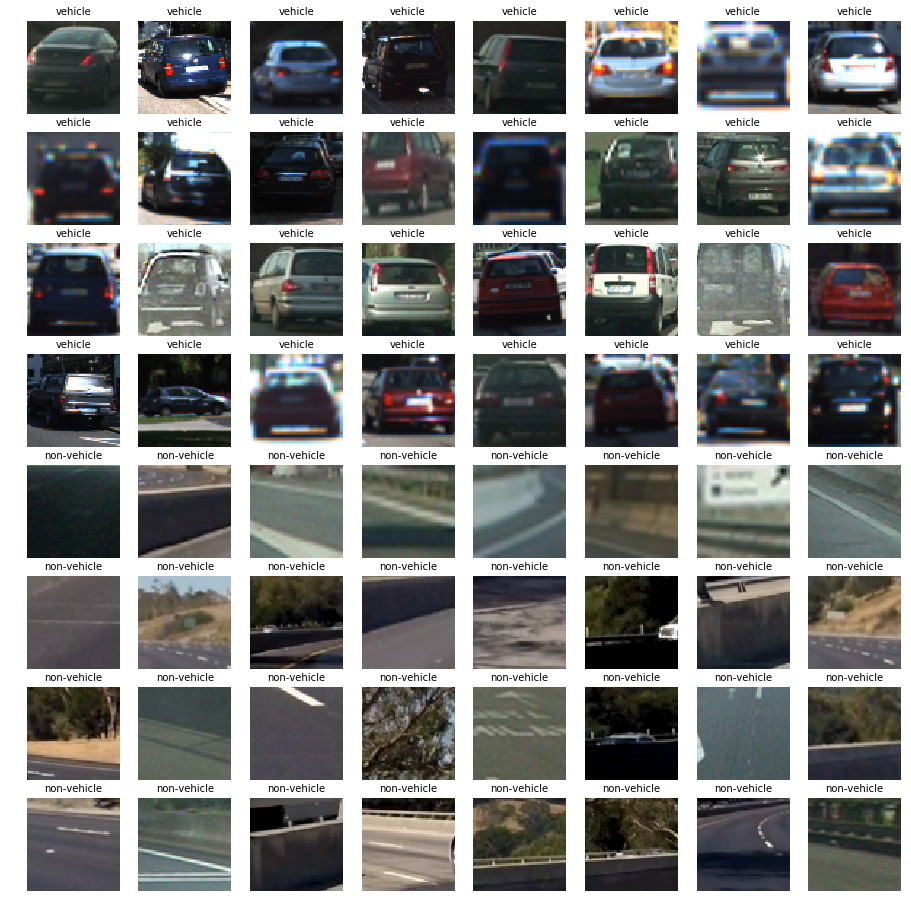

In [2]:
fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
# vehicle sample images
for i in range(0,32):
    img = plt.imread(vehicle_images[random.randint(0,len(vehicle_images))])
    axs[i].axis('off')
    axs[i].set_title('vehicle', fontsize=10)
    axs[i].imshow(img)
# non-vehicle sample images
for i in range(32,64):
    img = plt.imread(non_vehicle_images[random.randint(0,len(non_vehicle_images))])
    axs[i].axis('off')
    axs[i].set_title('non-vehicle', fontsize=10)
    axs[i].imshow(img)

In [3]:
## get_hog_features adapted from UDACITY lesson##
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

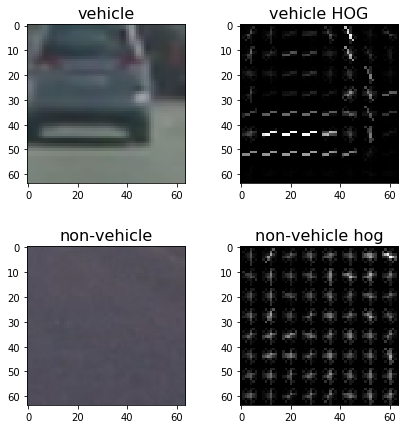

In [4]:
vehicle_img =  plt.imread(vehicle_images[random.randint(0,len(vehicle_images))])
vehicle_feat, vehicle_hog = get_hog_features(vehicle_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
non_vehicle_img = plt.imread(non_vehicle_images[random.randint(0,len(non_vehicle_images))])
non_vehicle_feat, non_vehicle_hog = get_hog_features(non_vehicle_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize random vehicle and nonvehicle
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(vehicle_img)
ax1.set_title('vehicle', fontsize=16)
#plt.imsave('output_images/sample_vehicle.jpg', vehicle_img)
ax2.imshow(vehicle_hog, cmap='gray')
ax2.set_title('vehicle HOG', fontsize=16)
#plt.imsave('output_images/sample_vehicle_HOG.jpg', vehicle_hog,cmap='gray')
ax3.imshow(non_vehicle_img)
ax3.set_title('non-vehicle', fontsize=16)
#plt.imsave('output_images/sample_non_vehicle.jpg', non_vehicle_img)
ax4.imshow(non_vehicle_hog, cmap='gray')
ax4.set_title('non-vehicle hog', fontsize=16)
#plt.imsave('output_images/sample_non_vehicle_hog.jpg', non_vehicle_hog, cmap='gray')


In [5]:
def get_all_hog_features(imgs):
    '''
    Funtion returns a list of all HOG feature arrays for every image in a passed list
    '''
    
    all_features = []

    for img in imgs:
        image = plt.imread(img)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        hog_features = []
        for channel in range(image.shape[2]):
            hog_features.append(get_hog_features(image[:,:,channel], 
                                11, 16, 2, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
       
        all_features.append(hog_features)
    return all_features

In [6]:
#process vehicle images
vehicle_features = get_all_hog_features(vehicle_images)
#process non-vehicle images
non_vehicle_features = get_all_hog_features(non_vehicle_images)
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64) 
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=rand_state)
print('Feature vector length:', len(X_train[0]))

Feature vector length: 1188


In [7]:
#Train a Support Vector to classify vehicles 
svc = LinearSVC()
print('training ...')
svc.fit(X_train, y_train)
print('accuracy:', round(svc.score(X_test, y_test), 4))

print('SVC predicts: ', svc.predict(X_test[0:15]))
print('real labels : ', y_test[0:15])

training ...
accuracy: 0.9811
SVC predicts:  [ 1.  1.  0.  1.  0.  1.  1.  1.  0.  0.  0.  1.  0.  1.  0.]
real labels :  [ 1.  1.  0.  1.  0.  1.  1.  1.  0.  0.  1.  1.  0.  1.  0.]


HLS training accuracy: 97.68

YUV training accuracy: 98.36

LAB training accuracy: 97.42

RGB training accuracy: 96.18

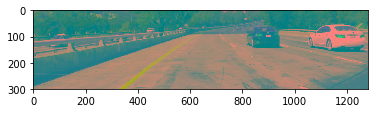

In [8]:
img1YUV = plt.imread("test_images/test1.jpg")
img1YUV = img1YUV[350:650,:,:]
img1YUV = cv2.cvtColor(img1YUV, cv2.COLOR_RGB2YUV)
img1YUV = img1YUV.astype(np.float32)/255
plt.imshow(img1YUV)
#plt.imsave('output_images/test1_YUV.jpg', img1YUV)

In [9]:
def find_cars(img, ystart, ystop,scale,svc,  
              pix_per_cell, cell_per_block):
   
    rectangles = []
    
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:]  
    img_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV) #YUV demonstrates the best SVM training accuracy after
                                                                    #testing four colorspaces
    
    imshape = img_tosearch.shape
    img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = img_tosearch[:,:,0]
    ch2 = img_tosearch[:,:,1]
    ch3 = img_tosearch[:,:,2]  

    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #in case -1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  
    nfeat_per_block = 11*cell_per_block**2
    
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    hog1 = get_hog_features(ch1, 11, pix_per_cell, cell_per_block, feature_vec=False)   
    hog2 = get_hog_features(ch2, 11, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, 11, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window]
            #print("hog_feat1: ", hog_feat1)
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window] 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window] 
            #hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            hog_features = []
            hog_features.append(hog_feat1)
            hog_features.append(hog_feat2)
            hog_features.append(hog_feat3)
            hog_features = np.ravel(hog_features)
            #print("hog_features: ", hog_features)
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
          
            test_prediction = svc.predict([hog_features])
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

##draw_boxes taken from UDACITY lesson##
def draw_boxes(img, bboxes, color=(255, 0, 0), thick=3):
    imcopy = np.copy(img)
    random_color = False
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

In [10]:
img1 = plt.imread("test_images/test1.jpg")
img2 = plt.imread("test_images/test2.jpg")
img3 = plt.imread("test_images/test3.jpg")
img4 = plt.imread("test_images/test4.jpg")
img5 = plt.imread("test_images/test5.jpg")
img6 = plt.imread("test_images/test6.jpg")

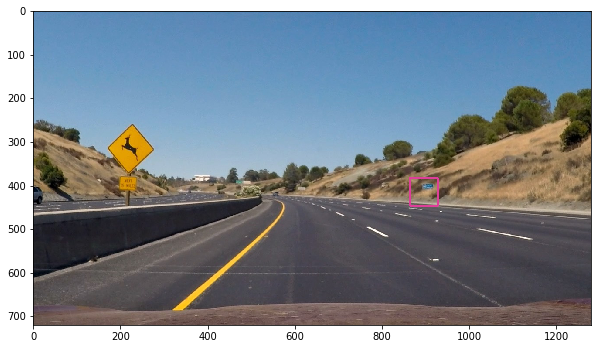

In [13]:
test_img  = img2
filename = 'test2'
ystart = 350
ystop = 650
pix_per_cell = 16
cell_per_block = 2

scales = [1,1.5,2,2.5,3]
rectangles = []
for scale in scales:
    rectangles = rectangles + find_cars(test_img, ystart, ystop,scale, svc, pix_per_cell, cell_per_block)
   
test_img_rects = draw_boxes(test_img, rectangles,'random')
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
#plt.imsave('output_images/'+filename+'.jpg', test_img_rects)

In [26]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

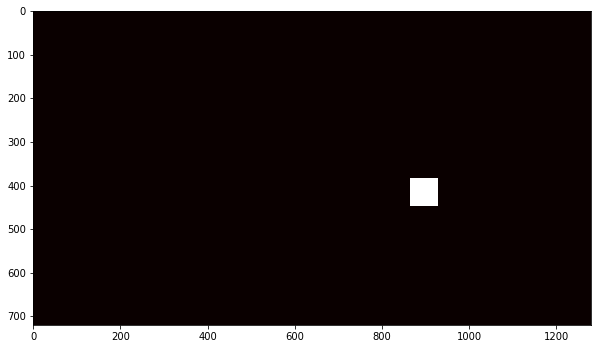

In [27]:
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')
#plt.imsave('output_images/test2_heatmap.jpg', heatmap_img, cmap='gray')

In [18]:
def heat_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

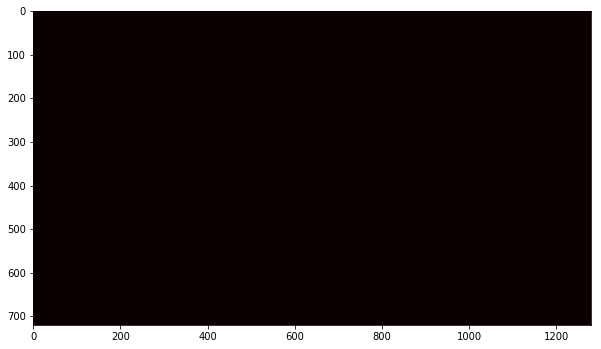

In [19]:
heatmap_img  = heat_threshold(heatmap_img, 2)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')
#plt.imsave('output_images/test6_heatmap_thresholded.jpg', heatmap_img, cmap='hot')

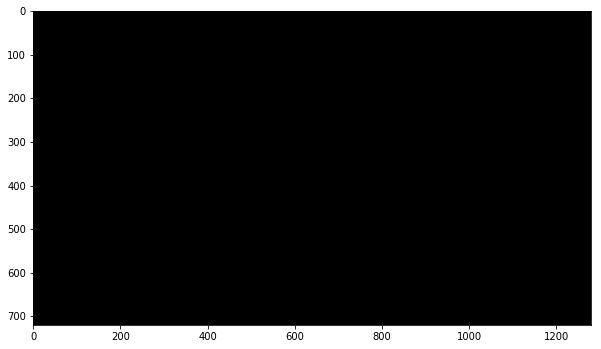

In [20]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap="gray")
plt.imsave('output_images/test2_heatmap_grayscale.jpg', labels[0], cmap='gray')

In [22]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

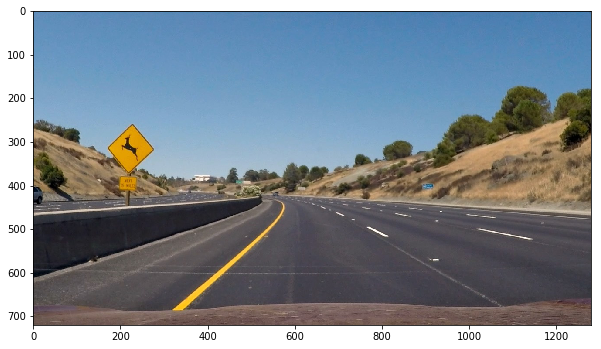

In [23]:
# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)
#plt.imsave('output_images/test1_bbox.jpg', draw_img)

In [24]:
def process_one_image(img):

    pix_per_cell = 16
    cell_per_block = 2
    ystart = 400
    ystop = 650
    scales = [1,1.5,2.0,2.5,3.0]
    rectangles = []
    for scale in scales:
        rectangles = rectangles + find_cars(img, ystart, ystop, scale,  svc, pix_per_cell, cell_per_block)

    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = heat_threshold(heatmap_img, 3)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

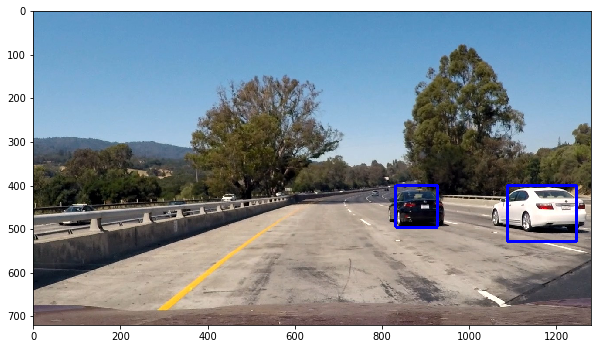

In [25]:
plt.figure(figsize=(10,10))
img1 = process_one_image(img1)
plt.imshow(img1)
plt.imsave('output_images/test1_processed.jpg', img1)

In [47]:
test_out = 'output_videos/test_video_out1_YUV.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test = clip_test.fl_image(process_one_image)
%time clip_test.write_videofile(test_out, audio=False)

[MoviePy] >>>> Building video output_videos/test_video_out1_YUV.mp4
[MoviePy] Writing video output_videos/test_video_out1_YUV.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:12<00:00,  2.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/test_video_out1_YUV.mp4 

Wall time: 14.1 s


Begin Video Construction

In [ ]:
class rect_history():
    def __init__(self):
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

In [ ]:
def process_one_image_for_video(img):

    pix_per_cell = 16
    cell_per_block = 2
    ystart = 400
    ystop = 650
    scales = [1,1.5,2.0,2.5,3.0]
    rectangles = []
    for scale in scales:
        rectangles = rectangles + find_cars(img, ystart, ystop, scale,  svc, pix_per_cell, cell_per_block)
    
    if rectangles:
        last.add_rects(rectangles)
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    
    for rect in last.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect)
    heatmap_img = heat_threshold(heatmap_img, 5+len(last.prev_rects))    
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [ ]:
last = rect_history()

test_out_smooth = 'output_videos/test_video_out2_YUV.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_smooth = clip_test.fl_image(process_one_image_for_video)
%time clip_test_smooth.write_videofile(test_out_smooth, audio=False)

In [ ]:
last = rect_history()

project_out_smooth = 'output_videos/project_video_out_YUV.mp4'
clip_project = VideoFileClip('project_video.mp4')
clip_project_smooth = clip_project.fl_image(process_one_image_for_video)
%time clip_project_smooth.write_videofile(project_out_smooth, audio=False)